<a href="https://colab.research.google.com/github/Conv-AI/TTS-Dev/blob/main/TTS_Finetuning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pre-requisites : Setting up the environment

In [1]:
#installs
BRANCH = 'r1.8.2'
!apt-get install sox libsndfile1 ffmpeg
!pip install wget unidecode pynini==2.1.4
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!pip install hydra-core==1.1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 45 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://a

In [2]:
!nvidia-smi

Wed Jun  8 14:43:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#helper functions
def infer(spec_gen_model, vocoder_model, str_input, speaker=None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Args:
        spec_gen_model: Spectrogram generator model (FastPitch in our case)
        vocoder_model: Vocoder model (HiFiGAN in our case)
        str_input: Text input for the synthesis
        speaker: Speaker ID
    
    Returns:
        spectrogram and waveform of the synthesized audio.
    """
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().to(device=spec_gen_model.device)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

def get_best_ckpt_from_last_run(
        base_dir, 
        new_speaker_id, 
        duration_mins, 
        mixing_enabled, 
        original_speaker_id, 
        model_name="FastPitch"
    ):    
    mixing = "no_mixing" if not mixing_enabled else "mixing"
    
    d = f"{original_speaker_id}_to_{new_speaker_id}_{mixing}_{duration_mins}_mins"
    
    exp_dirs = list([i for i in (Path(base_dir) / d / model_name).iterdir() if i.is_dir()])
    last_exp_dir = sorted(exp_dirs)[-1]
    
    last_checkpoint_dir = last_exp_dir / "checkpoints"
    
    last_ckpt = list(last_checkpoint_dir.glob('*-last.ckpt'))

    if len(last_ckpt) == 0:
        raise ValueError(f"There is no last checkpoint in {last_checkpoint_dir}.")
    
    return str(last_ckpt[0])

Finetuning FastPitch

In [6]:
#datasets : downloading and preparing
!wget https://nemo-public.s3.us-east-2.amazonaws.com/6097_5_mins.tar.gz  # Contains 10MB of data
!tar -xzf 6097_5_mins.tar.gz

!head -n 1 ./6097_5_mins/manifest.json

--2022-06-08 14:48:16--  https://nemo-public.s3.us-east-2.amazonaws.com/6097_5_mins.tar.gz
Resolving nemo-public.s3.us-east-2.amazonaws.com (nemo-public.s3.us-east-2.amazonaws.com)... 52.219.109.98
Connecting to nemo-public.s3.us-east-2.amazonaws.com (nemo-public.s3.us-east-2.amazonaws.com)|52.219.109.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11002569 (10M) [application/x-gzip]
Saving to: ‘6097_5_mins.tar.gz’

6097_5_mins.tar.gz  100%[===================>]  10.49M  16.5MB/s    in 0.6s    

2022-06-08 14:48:17 (16.5 MB/s) - ‘6097_5_mins.tar.gz’ saved [11002569/11002569]

{"audio_filepath": "audio/presentpictureofnsw_02_mann_0532.wav", "text": "not to stop more than ten minutes by the way", "duration": 2.6, "text_no_preprocessing": "not to stop more than ten minutes by the way,", "text_normalized": "not to stop more than ten minutes by the way,"}


In [7]:
!cat ./6097_5_mins/manifest.json | tail -n 93 > ./6097_manifest_dev_ns_all_local.json
!cat ./6097_5_mins/manifest.json | head -n -23 > ./6097_manifest_train_dur_5_mins_local.json


In [8]:
home_path = !(echo $HOME)
home_path = home_path[0]
print(home_path)

!ln -s ./6097_5_mins/audio audio

/root


In [9]:
#imports
import os
import json

import torch
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from pathlib import Path
import soundfile as sf
from pydub import AudioSegment 

In [10]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel

[NeMo W 2022-06-08 14:50:13 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-08 14:50:13 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [11]:
#getting the pre-trained model for fastpitch
FastPitchModel.from_pretrained("tts_en_fastpitch")
nemo_files = [p for p in Path(f"{home_path}/.cache/torch/NeMo/").glob("**/tts_en_fastpitch_align.nemo")]
print(f"Copying {nemo_files[0]} to ./")
Path("./tts_en_fastpitch_align.nemo").write_bytes(nemo_files[0].read_bytes())

[NeMo I 2022-06-08 14:50:14 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.8.1/files/tts_en_fastpitch_align.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo
[NeMo I 2022-06-08 14:50:19 common:747] Instantiating model from pre-trained checkpoint
[NeMo I 2022-06-08 14:50:20 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2022-06-08 14:50:25 g2ps:85] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-06-08 14:50:25 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: nu

[NeMo I 2022-06-08 14:50:25 features:259] PADDING: 1
[NeMo I 2022-06-08 14:50:25 features:276] STFT using torch
[NeMo I 2022-06-08 14:50:40 save_restore_connector:209] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo.
Copying /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo to ./


187023360

In [12]:
#get the finetuning file
!wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/fastpitch_finetune.py

!mkdir -p conf \
&& cd conf \
&& wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/fastpitch_align_v1.05.yaml \
&& cd ..

##additional files
!mkdir -p tts_dataset_files && cd tts_dataset_files \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.01 \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-030921 \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/en/data/whitelist_lj_speech.tsv \
&& cd ..

--2022-06-08 14:50:40--  https://raw.githubusercontent.com/nvidia/NeMo/r1.8.2/examples/tts/fastpitch_finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751 (1.7K) [text/plain]
Saving to: ‘fastpitch_finetune.py’

fastpitch_finetune. 100%[===================>]   1.71K  --.-KB/s    in 0s      

2022-06-08 14:50:41 (27.4 MB/s) - ‘fastpitch_finetune.py’ saved [1751/1751]

--2022-06-08 14:50:41--  https://raw.githubusercontent.com/nvidia/NeMo/r1.8.2/examples/tts/conf/fastpitch_align_v1.05.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

In [13]:
#finetuning the fastpitch model
!(python fastpitch_finetune.py --config-name=fastpitch_align_v1.05.yaml \
  train_dataset=./6097_manifest_train_dur_5_mins_local.json \
  validation_datasets=./6097_manifest_dev_ns_all_local.json \
  sup_data_path=./fastpitch_sup_data \
  phoneme_dict_path=tts_dataset_files/cmudict-0.7b_nv22.01 \
  heteronyms_path=tts_dataset_files/heteronyms-030921 \
  whitelist_path=tts_dataset_files/whitelist_lj_speech.tsv \
  exp_manager.exp_dir=./ljspeech_to_6097_no_mixing_5_mins \
  +init_from_nemo_model=./tts_en_fastpitch_align.nemo \
  +trainer.max_steps=1000 ~trainer.max_epochs \
  trainer.check_val_every_n_epoch=25 \
  model.train_ds.dataloader_params.batch_size=24 model.validation_ds.dataloader_params.batch_size=24 \
  model.n_speakers=1 model.pitch_mean=121.9 model.pitch_std=23.1 \
  model.pitch_fmin=30 model.pitch_fmax=512 model.optim.lr=2e-4 \
  ~model.optim.sched model.optim.name=adam trainer.devices=1 trainer.strategy=null \
  +model.text_tokenizer.add_blank_at=true \
)

[NeMo W 2022-06-08 14:50:47 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-08 14:50:48 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-0

In [14]:
new_speaker_id = 6097
duration_mins = 5
mixing = False
original_speaker_id = "ljspeech"

In [15]:
last_ckpt = get_best_ckpt_from_last_run("./", new_speaker_id, duration_mins, mixing, original_speaker_id)
print(last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda()

ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-06-08_14-50-49/checkpoints/FastPitch--v_loss=0.3751-epoch=249-last.ckpt
[NeMo I 2022-06-08 15:26:53 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2022-06-08 15:26:58 g2ps:85] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-06-08 15:26:58 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./6097_manifest_train_dur_5_mins_local.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim:

[NeMo I 2022-06-08 15:26:58 features:259] PADDING: 1
[NeMo I 2022-06-08 15:26:58 features:276] STFT using torch


FastPitchModel(
  (mel_loss): MelLoss()
  (pitch_loss): PitchLoss()
  (duration_loss): DurationLoss()
  (aligner): AlignmentEncoder(
    (softmax): Softmax(dim=3)
    (log_softmax): LogSoftmax(dim=3)
    (key_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(384, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(768, 80, kernel_size=(1,), stride=(1,))
      )
    )
    (query_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(80, 160, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(160, 80, kernel_size=(1,), stride=(1,))
      )
      (3): ReLU()
      (4): ConvNorm(
        (conv): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (forward_sum_loss): ForwardSumLoss(
    (log_softmax): LogSoftmax(dim=3)
    (ctc_loss): CTCLoss()
  )
  (bin_loss): BinLoss()
  (preprocessor): AudioToMelSpectrogramPreprocessor(
  

In [57]:
#save the model--> gdrive
!cp /content/ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-06-08_14-50-49/checkpoints/FastPitch--v_loss=0.3751-epoch=249-last.ckpt -t /content/drive/MyDrive/TTS-Convai

In [16]:
#trying it out 
vocoder = HifiGanModel.from_pretrained("tts_hifigan")
vocoder = vocoder.eval().cuda()

[NeMo I 2022-06-08 15:27:16 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-06-08 15:27:24 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-06-08 15:27:27 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-06-08 15:27:27 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-06-08 15:27:27 features:259] PADDING: 0
[NeMo I 2022-06-08 15:27:27 features:276] STFT using torch


[NeMo W 2022-06-08 15:27:27 features:234] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-06-08 15:27:27 features:259] PADDING: 0
[NeMo I 2022-06-08 15:27:27 features:276] STFT using torch
[NeMo I 2022-06-08 15:27:28 save_restore_connector:209] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: does the lily then live as the soldier thought


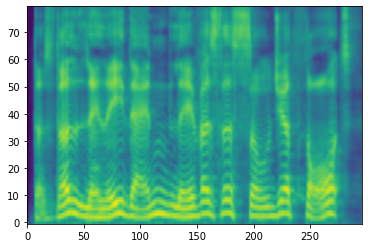

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: answered the prayer doctor


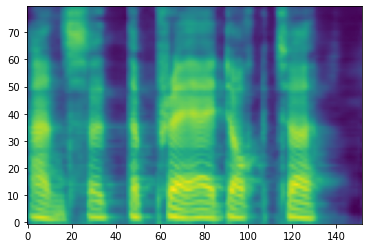

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: where the bones of the boy should be


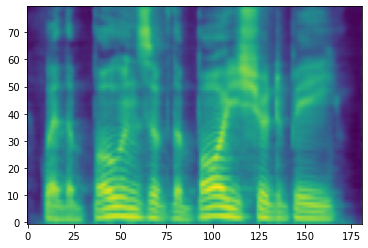

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: in a great measure


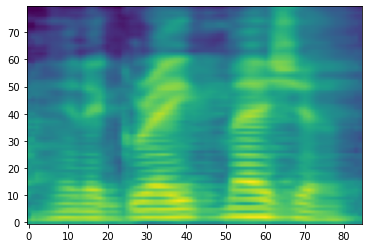

In [18]:
# Only need to set speaker_id if there is more than one speaker
speaker_id = None
if mixing:
    speaker_id = 1

num_val = 4  # Number of validation samples
val_records = []
with open(f"{new_speaker_id}_manifest_dev_ns_all_local.json", "r") as f:
    for i, line in enumerate(f):
        val_records.append(json.loads(line))
        if len(val_records) >= num_val:
            break
            
for val_record in val_records:
    print("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
    print(f"SYNTHESIZED FOR -- Speaker: {new_speaker_id} | Dataset size: {duration_mins} mins | Mixing:{mixing} | Text: {val_record['text']}")
    spec, audio = infer(spec_model, vocoder, val_record['text'], speaker=speaker_id)
    ipd.display(ipd.Audio(audio, rate=22050))
    %matplotlib inline
    imshow(spec, origin="lower", aspect="auto")
    plt.show()

Finetuning HiFiGAN

In [19]:
#imports
from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator
import librosa
import soundfile as sf
import numpy as np

In [20]:
#helper functions
def load_wav(audio_file, target_sr=None):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
        sample_rate = f.samplerate
        if target_sr is not None and target_sr != sample_rate:
            samples = librosa.core.resample(samples, orig_sr=sample_rate, target_sr=target_sr)
    return samples.transpose()

In [21]:
#dataset preparation
# Get records from the training manifest
manifest_path = "./6097_manifest_train_dur_5_mins_local.json"
records = []
with open(manifest_path, "r") as f:
    for i, line in enumerate(f):
        records.append(json.loads(line))

beta_binomial_interpolator = BetaBinomialInterpolator()
spec_model.eval()

device = spec_model.device

save_dir = Path("./6097_manifest_train_dur_5_mins_local_mels")
save_dir.mkdir(exist_ok=True, parents=True)

# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records):
    audio = load_wav(r["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    
    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None
    
    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])
        
        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
            
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
        
        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

hifigan_manifest_path = "hifigan_train_ft.json"
with open(hifigan_manifest_path, "w") as f:
    for r in records:
        f.write(json.dumps(r) + '\n')

[NeMo W 2022-06-08 15:30:19 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
      warnings.warn(problem)
    


In [22]:
# Get records from the training manifest
manifest_path_validation = "./6097_manifest_dev_ns_all_local.json"
records_val = []
with open(manifest_path_validation, "r") as f:
    for i, line in enumerate(f):
        records_val.append(json.loads(line))

save_dir_val = Path("./6097_manifest_dev_ns_all_local_mels")
save_dir_val.mkdir(exist_ok=True, parents=True)

# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records_val):
    audio = load_wav(r["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    
    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None
    
    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])
        
        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
            
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
        
        save_path_val = save_dir_val / f"mel_{i}.npy"
        np.save(save_path_val, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path_val)

hifigan_val_manifest_path = "hifigan_val_ft.json"
with open(hifigan_val_manifest_path, "w") as f:
    for r in records_val:
        f.write(json.dumps(r) + '\n')

In [23]:
#downloading and unzipping the necessary files
! mv hifigan.zip -t ./conf/
! cd conf && unzip hifigan.zip && cd ..
! wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/hifigan_finetune.py
! cd conf && cd hifigan && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/hifigan.yaml && cd .. && cd ..

Archive:  hifigan.zip
   creating: hifigan/
   creating: hifigan/model/
   creating: hifigan/model/validation_ds/
 extracting: hifigan/model/validation_ds/val_ds.yaml  
 extracting: hifigan/model/validation_ds/val_ds_finetune.yaml  
   creating: hifigan/model/train_ds/
 extracting: hifigan/model/train_ds/train_ds.yaml  
 extracting: hifigan/model/train_ds/train_ds_finetune.yaml  
   creating: hifigan/model/generator/
 extracting: hifigan/model/generator/v1.yaml  
 extracting: hifigan/model/generator/v1_44100.yaml  
 extracting: hifigan/model/generator/v2.yaml  
 extracting: hifigan/model/generator/v3.yaml  
 extracting: hifigan/hifigan.yaml    
 extracting: hifigan/hifigan_44100.yaml  
--2022-06-08 15:31:31--  https://raw.githubusercontent.com/nvidia/NeMo/r1.8.2/examples/tts/hifigan_finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.

In [24]:
#getting the pre-trained model for hifigan
nemo_files = [p for p in Path(f"{home_path}/.cache/torch/NeMo/").glob("**/tts_hifigan.nemo")]
print(f"Copying {nemo_files[0]} to ./")
Path("./tts_hifigan.nemo").write_bytes(nemo_files[0].read_bytes())

Copying /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo to ./


315386678

In [25]:
#remove the FastPitch & HiFiGAN model from the GPU memory
del spec_model
del vocoder

In [27]:
#finetuning the hifigan model
!(python hifigan_finetune.py \
--config-name=hifigan.yaml \
model.train_ds.dataloader_params.batch_size=16 \
model.max_steps=1000 \
model.optim.lr=0.0001 \
~model.optim.sched \
train_dataset=./hifigan_train_ft.json \
validation_datasets=./hifigan_val_ft.json \
exp_manager.exp_dir=hifigan_ft \
+init_from_nemo_model=tts_hifigan.nemo \
trainer.check_val_every_n_epoch=10 \
)

[NeMo W 2022-06-08 16:10:10 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-08 16:10:11 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-06-08 16:10:12 exp_manager:281] Experiments will be 

In [58]:
#save the model--> gdrive
!cp /content/hifigan_ft/HifiGan/2022-06-08_16-10-12/checkpoints/HifiGan--val_loss=0.4266-epoch=79-last.ckpt -t /content/drive/MyDrive/TTS-Convai

Inferencing with the finetuned model : 

In [30]:
#inferencing
last_ckpt1 = get_best_ckpt_from_last_run("./", new_speaker_id, duration_mins, mixing, original_speaker_id)
print(last_ckpt1)
spec_model = FastPitchModel.load_from_checkpoint(last_ckpt1)
spec_model.eval().cuda()

last_ckpt2 = "/content/hifigan_ft/HifiGan/2022-06-08_16-10-12/checkpoints/HifiGan--val_loss=0.4266-epoch=79-last.ckpt"
print(last_ckpt2)
vocoder = HifiGanModel.load_from_checkpoint(last_ckpt2)
vocoder = vocoder.eval().cuda()


ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-06-08_14-50-49/checkpoints/FastPitch--v_loss=0.3751-epoch=249-last.ckpt
[NeMo I 2022-06-08 16:34:37 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2022-06-08 16:34:41 g2ps:85] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-06-08 16:34:41 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./6097_manifest_train_dur_5_mins_local.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim:

[NeMo I 2022-06-08 16:34:41 features:259] PADDING: 1
[NeMo I 2022-06-08 16:34:41 features:276] STFT using torch
/content/hifigan_ft/HifiGan/2022-06-08_16-10-12/checkpoints/HifiGan--val_loss=0.4266-epoch=79-last.ckpt


[NeMo W 2022-06-08 16:34:47 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: ./hifigan_train_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
    
[NeMo W 2022-06-08 16:34:47 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: ./hifigan_val_ft.json
      sample_rate: 22050
      n_s

[NeMo I 2022-06-08 16:34:47 features:259] PADDING: 0
[NeMo I 2022-06-08 16:34:47 features:276] STFT using torch
[NeMo I 2022-06-08 16:34:47 features:278] STFT using exact pad
[NeMo I 2022-06-08 16:34:47 features:259] PADDING: 0
[NeMo I 2022-06-08 16:34:47 features:276] STFT using torch
[NeMo I 2022-06-08 16:34:47 features:278] STFT using exact pad


Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: does the lily then live as the soldier thought


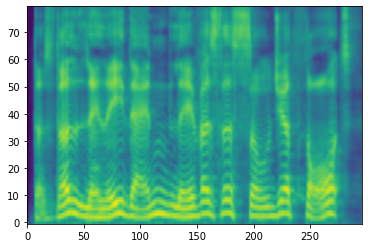

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: answered the prayer doctor


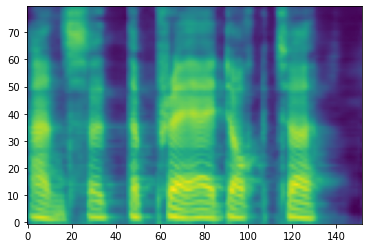

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: where the bones of the boy should be


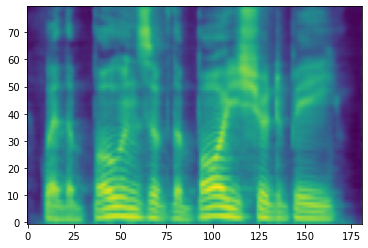

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: in a great measure


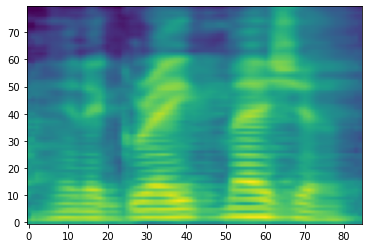

In [31]:
# Only need to set speaker_id if there is more than one speaker
speaker_id = None
if mixing:
    speaker_id = 1

num_val = 4  # Number of validation samples
val_records = []
with open(f"{new_speaker_id}_manifest_dev_ns_all_local.json", "r") as f:
    for i, line in enumerate(f):
        val_records.append(json.loads(line))
        if len(val_records) >= num_val:
            break
            
for val_record in val_records:
    print("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
    print(f"SYNTHESIZED FOR -- Speaker: {new_speaker_id} | Dataset size: {duration_mins} mins | Mixing:{mixing} | Text: {val_record['text']}")
    spec, audio = infer(spec_model, vocoder, val_record['text'], speaker=speaker_id)
    ipd.display(ipd.Audio(audio, rate=22500))
    %matplotlib inline
    imshow(spec, origin="lower", aspect="auto")
    plt.show()

In [ ]:
from  scipy.io import wavfile

In [51]:
def custom_infer(transcript, spec_model, vocoder, download=None):
  spec, audio = infer(spec_model, vocoder, transcript)
  print("\n\n\n\n")
  ipd.display(ipd.Audio(audio, rate=22050))
  %matplotlib inline
  plt.show()

In [59]:
transcript = "Hello I am Ben."

In [60]:
custom_infer(transcript, spec_model, vocoder, "x.wav")